In [6]:
import os
import numpy as np
import pandas as pd 
#import seaborn as sns
from matplotlib import pyplot as plt
%matplotlib inline
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, BatchNormalization
from tensorflow.keras.callbacks import ModelCheckpoint
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.svm import LinearSVC

In [10]:
# Import the dataset

path = os.path.join('datasets', 'creditcard', 'creditcard.csv')
pf = pd.read_csv(path)

In [11]:
# First five rows of the dataset
pf.head()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


#### This dataset includes 
- **30 features**
- one label column which is the **class of the transaction**, **0** for **not_fraud** and **1** for **fraud**
- No **null value**


In [12]:
pf.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

### Class imbalance

As expected, the credit card dataset is imbalanced, which means there are too many non-fraudulent (normal) transactions compared to fraudulent ones. 
In our case, there are: 
- **284315** normal transactions against only 
- **492** fraudulent transactions. 

As we'll see, this skewed data can affect the accuracy of models. 
One solution to fix it, is to make the dataset more symmetric with the same number of instances for both classes.

But let's first work with the skewed dataset to see its effects!!! 


In [13]:
pf["Class"].value_counts()

Class
0    284315
1       492
Name: count, dtype: int64

### Feature scaling

Features have different scale! 

With the data description and histograms, we can see that 
- **V's features** are spread around **0** while
- **Time** and **Amount** ranges respectively from  **0** to **172792** and  **0** to **25691**.

This can affect the efficiency of the gradient descent algorithm. Indeed, it may take too long to converge.

To avoid this problem, we need to perform a data transformation called **feature scaling** on our features Time and Amount.
I'll apply the MinMax Normalization: 
$$x_i = \dfrac{x_i - min}{max - min} $$

In [14]:
# Quick statistical insights
pf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


array([[<Axes: title={'center': 'Time'}>, <Axes: title={'center': 'V1'}>,
        <Axes: title={'center': 'V2'}>, <Axes: title={'center': 'V3'}>,
        <Axes: title={'center': 'V4'}>, <Axes: title={'center': 'V5'}>],
       [<Axes: title={'center': 'V6'}>, <Axes: title={'center': 'V7'}>,
        <Axes: title={'center': 'V8'}>, <Axes: title={'center': 'V9'}>,
        <Axes: title={'center': 'V10'}>, <Axes: title={'center': 'V11'}>],
       [<Axes: title={'center': 'V12'}>, <Axes: title={'center': 'V13'}>,
        <Axes: title={'center': 'V14'}>, <Axes: title={'center': 'V15'}>,
        <Axes: title={'center': 'V16'}>, <Axes: title={'center': 'V17'}>],
       [<Axes: title={'center': 'V18'}>, <Axes: title={'center': 'V19'}>,
        <Axes: title={'center': 'V20'}>, <Axes: title={'center': 'V21'}>,
        <Axes: title={'center': 'V22'}>, <Axes: title={'center': 'V23'}>],
       [<Axes: title={'center': 'V24'}>, <Axes: title={'center': 'V25'}>,
        <Axes: title={'center': 'V26'}>, <

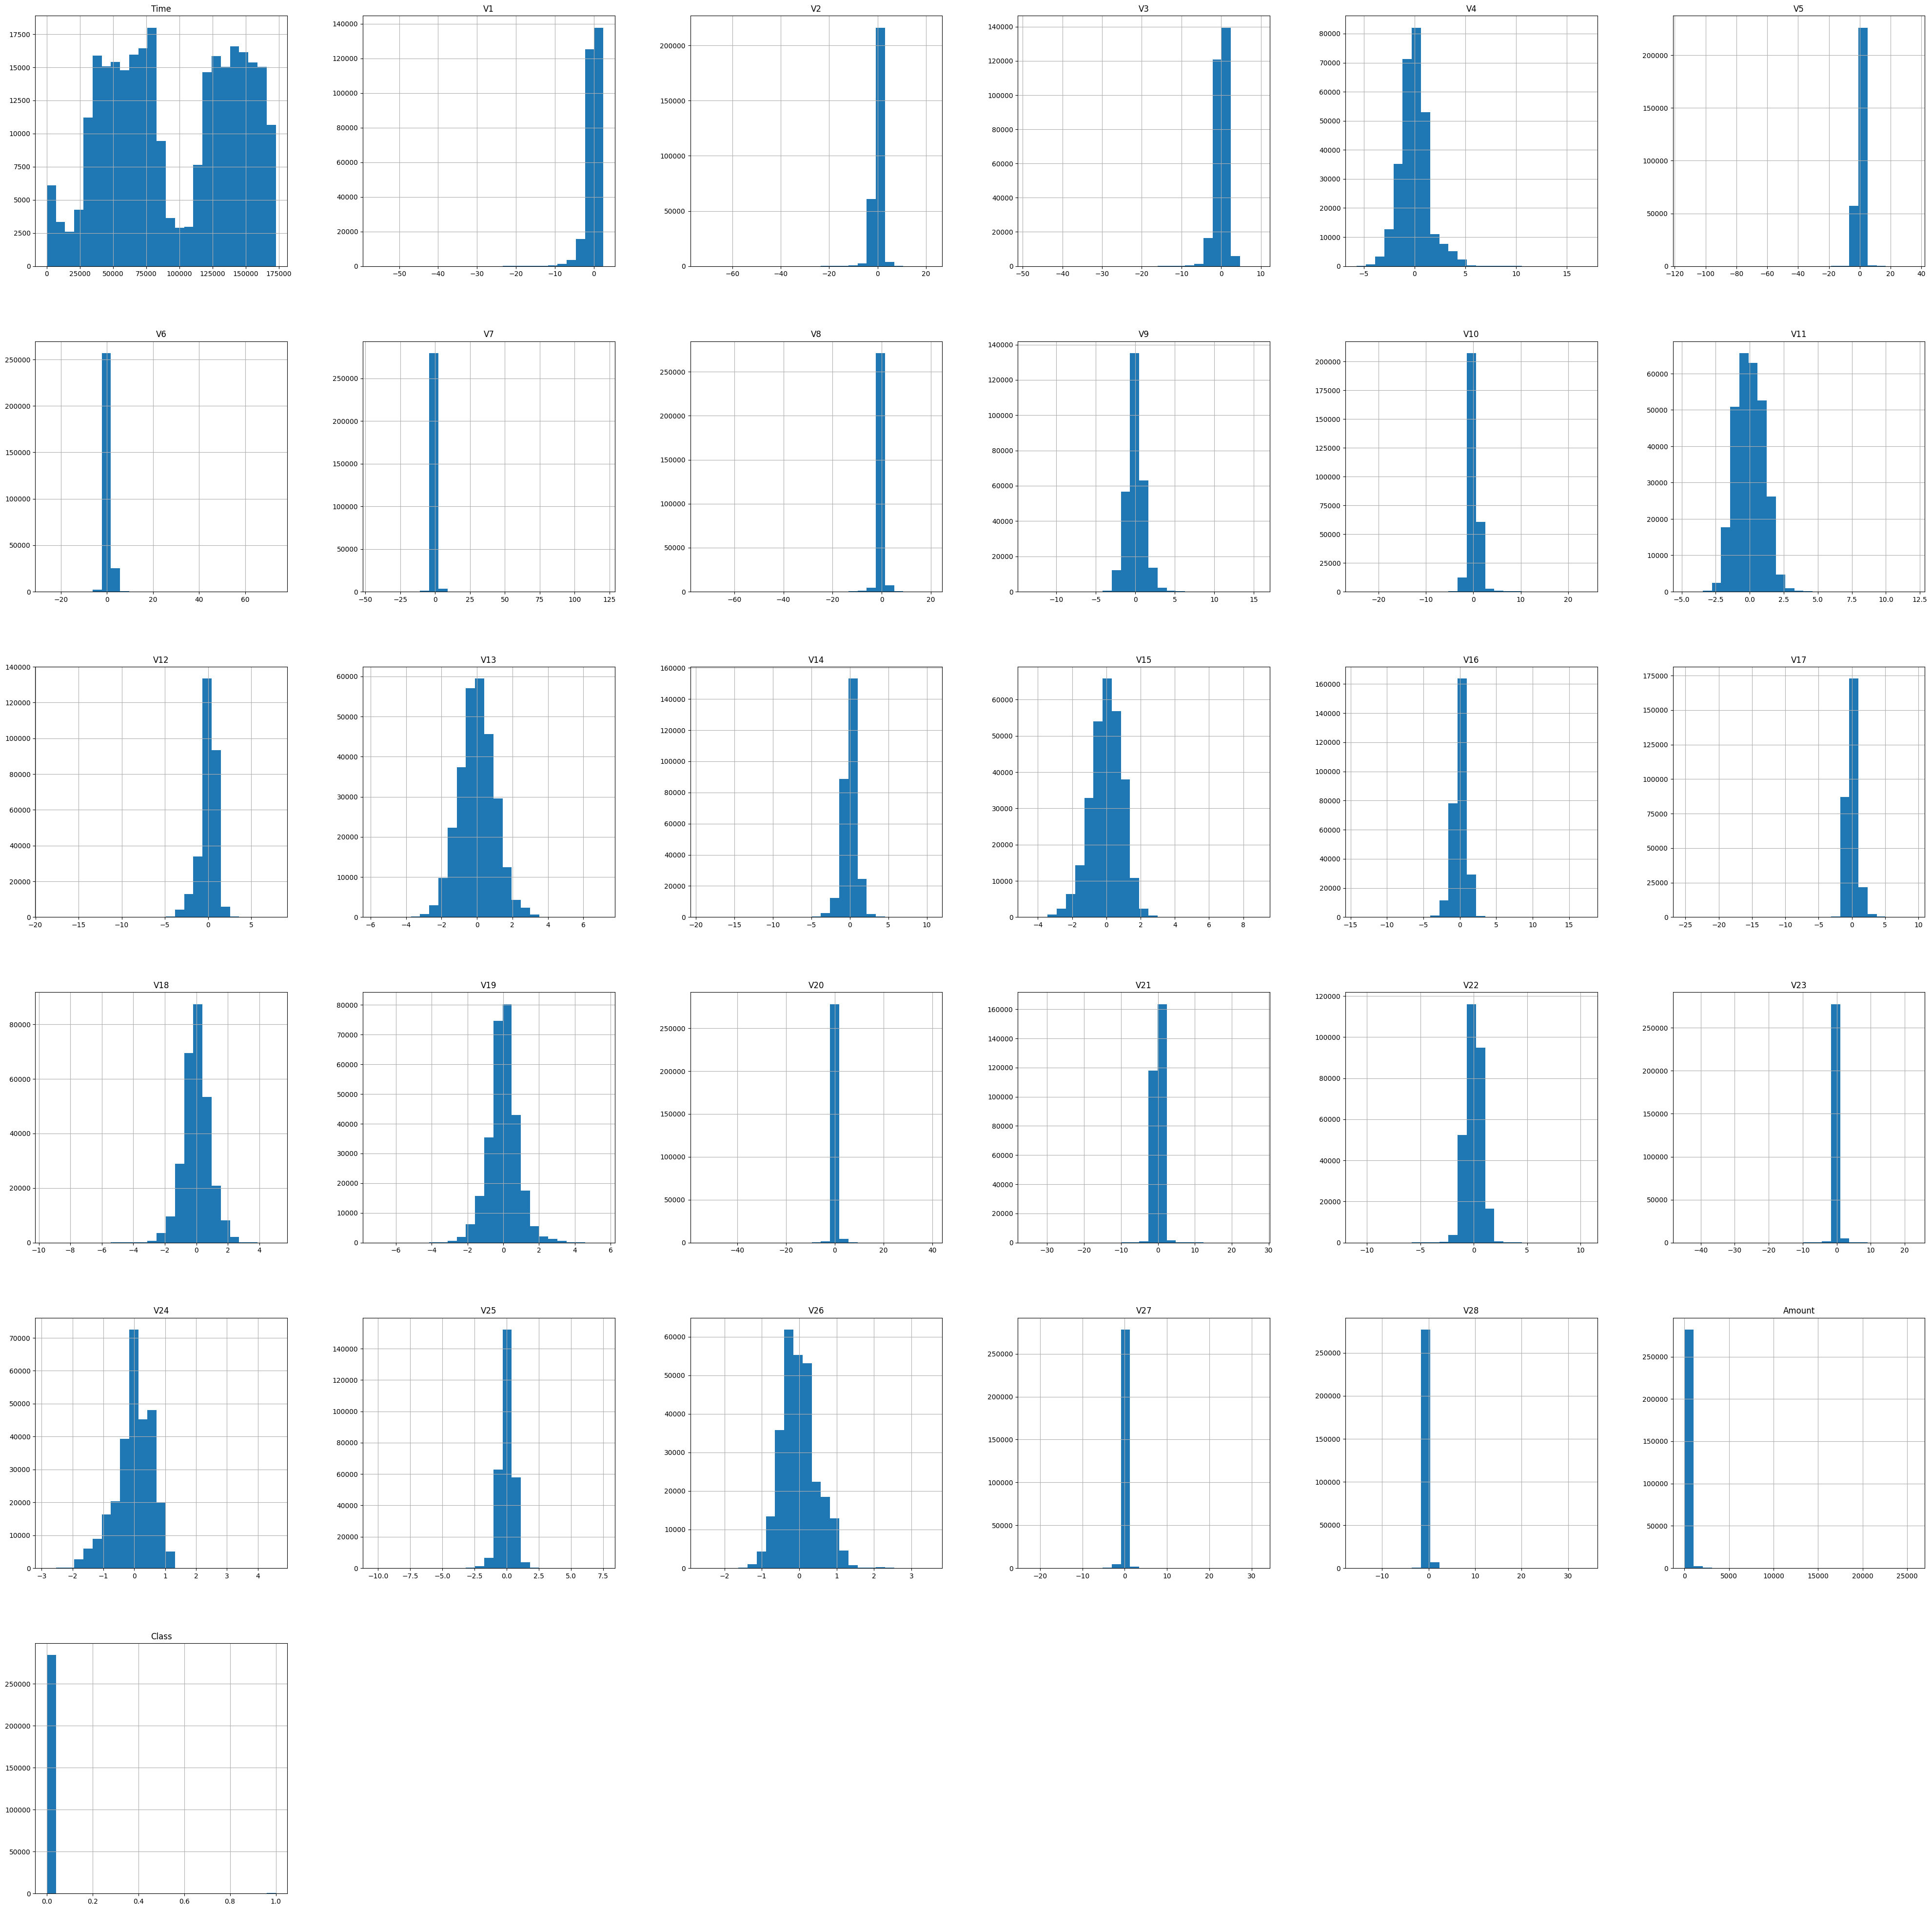

In [20]:
pf.hist(bins=25, figsize=(50,50))

<Axes: >

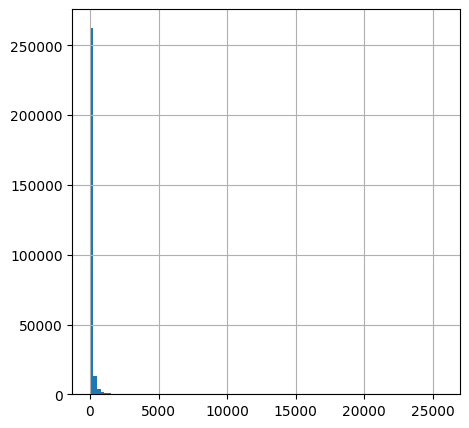

In [24]:
#Zoom in on the amount feature
pf["Amount"].hist(bins=100, figsize=(5,5))

<Axes: >

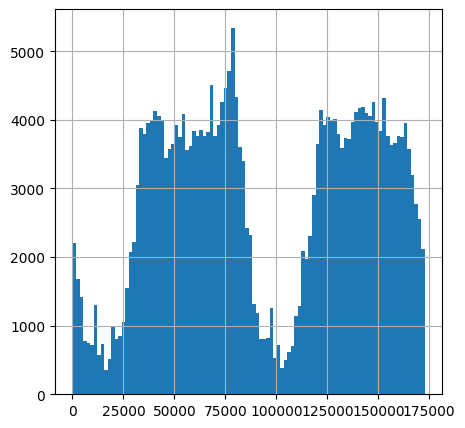

In [25]:
# Zoom in on the Time feature
pf["Time"].hist(bins=100, figsize=(5,5))

In [26]:
# MinMax normalization 
new_pf = pf.copy()
new_pf["Time"]= MinMaxScaler().fit_transform(new_pf["Time"].to_numpy().reshape(-1,1))
new_pf["Amount"]=MinMaxScaler().fit_transform(new_pf["Amount"].to_numpy().reshape(-1,1))


In [27]:
new_pf.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,...,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,0.548717,1.168375e-15,3.416908e-16,-1.379537e-15,2.074095e-15,9.604066e-16,1.487313e-15,-5.556467e-16,1.213481e-16,-2.406331e-15,...,1.654067e-16,-3.568593e-16,2.578648e-16,4.473266e-15,5.340915e-16,1.683437e-15,-3.660091e-16,-1.227390e-16,0.003439,0.001727
std,0.274828,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,...,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,0.009736,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,...,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,0.313681,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,...,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,0.000218,0.000000
50%,0.490138,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,...,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,0.000856,0.000000
75%,0.806290,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,...,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,0.003004,0.000000
max,1.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,...,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,1.000000,1.000000


In [40]:
# How would you rescale the entire dataset at once?

# pf_just_for_review = pf.copy()
# # The fit_transform method learns the parameters from the training data (fit) and then 
# # applies the transformation using those learned parameters (transform) in one step.
# new_pf_just_for_review = MinMaxScaler().fit_transform(pf_just_for_review.to_numpy())

# # Convert numpy array back to DataFrame
# new_pf_just_for_review = pd.DataFrame(new_pf_just_for_review, columns=pf_just_for_review.columns)
# new_pf_just_for_review.describe()

#### Separate the features from the ground truth

In [28]:
Y = new_pf["Class"]
X = new_pf.drop("Class", axis=1)

In [29]:
X.shape

(284807, 30)

#### Split the dataset into train, validation and test set

In [30]:
x_train,x_,y_train,y_ = train_test_split(X, Y, test_size= 0.4, random_state=0)
x_test,x_val,y_test,y_val = train_test_split(x_, y_, test_size= 0.5, random_state=0)

# Delete temporary variables x_ and y_
del x_,y_ 

# Model building!

### Logistic Regression

We're dealing with a classification problem! Given a transaction, our model should predict wheither it's fraudulent (1) or non-fraudulent(0) transaction. 

The logistic regression is one of the core ML classification algorithms. 
the logistic regression name might be a bit confusing, the regression part comes from the fact that the mathematical formulation of the logistic regression is very similar to that of the linear regression.

- In linear regression, the predictive function or model ${y_i}$ is defined as linear combination of the input data ${x_i}$ : ${y_i} = {w^{T}}{x_i} + {b}$ where (w,b) are the model parameters.


- In Logistic regression, the output takes discrete values, in this case 0 or 1 (binary classification) and therefore the predictive function defined earlier for linear regression would not work. We apply the logistic function to the linear combination of the input data. You can think of this function as the probability of a transaction being fraudulent. Obviously, it ranges from 0 to 1: depending on a threshold, transactions with probability value higher than the threshold would be classified as fraudulent and those with less than the threshold are the normal ones. The predictive function for logistic regression is defined as follow:


$${f_{w,b}({x_i})} = \frac{1}{1+\exp^{-({w^{T}}{x_i} + {b})}}$$

Once we get to this point, we need to define the **cost function** ${J({w,b})}$ which measures the likelihood of the data given our model. It defines how likely an instance is according to our model. The cost function is defined by the **Maximum likelihood estimation (MLE)** as followed: 

$$ J({w,b}) = \frac{1}{m}\sum\limits_{i = 1}^{m}(-y_{i})\log\left(f_{\mathbf{w},b}\left( \mathbf{x}_{i} \right) \right) - \left( 1 - y_{i}\right) \log \left( 1 - f_{\mathbf{w},b}\left( \mathbf{x}_{i} \right) \right)$$

Instead of working with the log likelihood, we choose the Negative log likelihood since most of the optimization algorithms are designed to minimize cost function.

**Gradient descent** is then applied to find parameters $\mathbf(w,b)$ that minimize $J({w,b})$.

The main differences are related to nature of the output (continuous or categorical) and the predictive function.

In [41]:
logistic_model = LogisticRegression(max_iter=200)

logistic_model.fit(x_train, y_train)


print(classification_report(y_val, logistic_model.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.88      0.62      0.73       109

    accuracy                           1.00     56962
   macro avg       0.94      0.81      0.87     56962
weighted avg       1.00      1.00      1.00     56962



=========================================================================================================================


In [92]:
shallow_nn = Sequential()
shallow_nn.add(InputLayer(x_train.shape[1],))
shallow_nn.add(Dense(3,'relu'))
shallow_nn.add(BatchNormalization())
shallow_nn.add(Dense(1,'sigmoid'))

checkpoint = ModelCheckpoint('shallow_nn', save_best_only=True) # save the best model with respect to the accuracy
shallow_nn.compile(loss='binary_crossentropy', optimizer='adam',metrics=['accuracy'])

In [93]:
shallow_nn.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 93        
                                                                 
 batch_normalization (Batch  (None, 3)                 12        
 Normalization)                                                  
                                                                 
 dense_1 (Dense)             (None, 1)                 4         
                                                                 
Total params: 109 (436.00 Byte)
Trainable params: 103 (412.00 Byte)
Non-trainable params: 6 (24.00 Byte)
_________________________________________________________________


In [94]:
shallow_nn.fit(x_train,y_train, validation_data = (x_val,y_val), epochs = 5, callbacks = checkpoint)

Epoch 1/5
5338/5341 [============================>.] - ETA: 0s - loss: 0.0601 - accuracy: 0.9808INFO:tensorflow:Assets written to: shallow_nn\assets


INFO:tensorflow:Assets written to: shallow_nn\assets


5341/5341 [==============================] - 52s 9ms/step - loss: 0.0601 - accuracy: 0.9808 - val_loss: 0.0063 - val_accuracy: 0.9992
Epoch 2/5
5336/5341 [============================>.] - ETA: 0s - loss: 0.0034 - accuracy: 0.9993INFO:tensorflow:Assets written to: shallow_nn\assets


INFO:tensorflow:Assets written to: shallow_nn\assets


5341/5341 [==============================] - 51s 10ms/step - loss: 0.0033 - accuracy: 0.9993 - val_loss: 0.0062 - val_accuracy: 0.9992
Epoch 3/5
5339/5341 [============================>.] - ETA: 0s - loss: 0.0032 - accuracy: 0.9993INFO:tensorflow:Assets written to: shallow_nn\assets


INFO:tensorflow:Assets written to: shallow_nn\assets


5341/5341 [==============================] - 50s 9ms/step - loss: 0.0032 - accuracy: 0.9993 - val_loss: 0.0057 - val_accuracy: 0.9993
Epoch 4/5
5341/5341 [==============================] - 51s 10ms/step - loss: 0.0032 - accuracy: 0.9994 - val_loss: 0.0070 - val_accuracy: 0.9992
Epoch 5/5
5341/5341 [==============================] - 59s 11ms/step - loss: 0.0031 - accuracy: 0.9993 - val_loss: 0.0067 - val_accuracy: 0.9992


In [101]:
def shallow_nn_predict(model, x):
    return (model.predict(x).flatten() > 0.5).astype(int)

shallow_nn_predict(shallow_nn, x_val)

1781/1781 [==============================] - 6s 4ms/step


array([0, 0, 0, ..., 0, 0, 0])

In [100]:
print(classification_report(y_val, shallow_nn_predict(shallow_nn, x_val), target_names = ['Non Fraud','Fraud']))

1781/1781 [==============================] - 10s 5ms/step
              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.78      0.83      0.80       109

    accuracy                           1.00     56962
   macro avg       0.89      0.91      0.90     56962
weighted avg       1.00      1.00      1.00     56962



In [20]:
x = np.arange(0.,1.1,0.1)
y_1 = -np.log(x)
y_2 = -np.log(1-x)

C:\Users\segna\AppData\Local\Temp\ipykernel_11764\3404600916.py:2: RuntimeWarning: divide by zero encountered in log
  y_1 = -np.log(x)
C:\Users\segna\AppData\Local\Temp\ipykernel_11764\3404600916.py:3: RuntimeWarning: divide by zero encountered in log
  y_2 = -np.log(1-x)


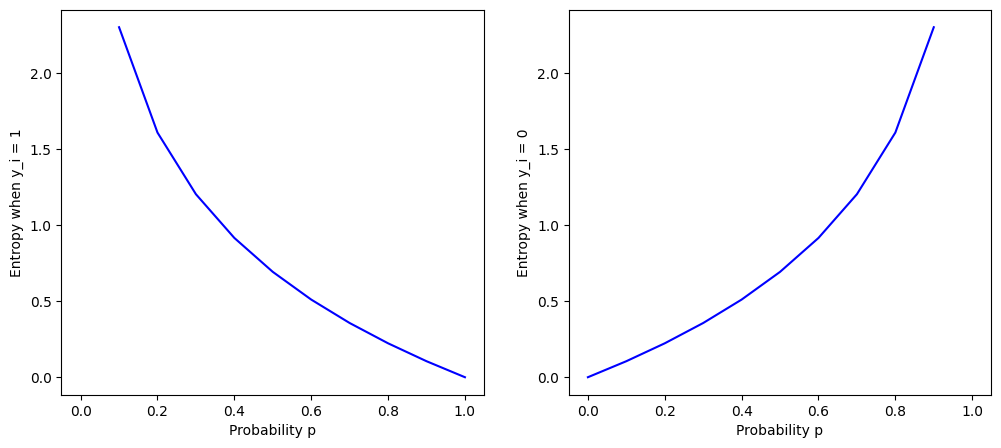

In [27]:
fig,ax = plt.subplots(1,2, figsize=(12,5), sharex=True)
ax[0].plot(x,y_1, c='blue')
ax[0].set_xlabel('Probability p')
ax[0].set_ylabel('Entropy when y_i = 1')
ax[1].plot(x,y_2, c='blue')
ax[1].set_ylabel('Entropy when y_i = 0')
ax[1].set_xlabel('Probability p')
plt.show()

In [42]:
rf = RandomForestClassifier(max_depth=2, n_jobs=-1)
rf.fit(x_train,y_train)

print(classification_report(y_val, rf.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.83      0.59      0.69       109

    accuracy                           1.00     56962
   macro avg       0.92      0.79      0.84     56962
weighted avg       1.00      1.00      1.00     56962



In [45]:
xgb = GradientBoostingClassifier(n_estimators=75,max_depth=2, learning_rate= 1.0, random_state=0)
xgb.fit(x_train,y_train)

print(classification_report(y_val, xgb.predict(x_val), target_names = ['Non Fraud','Fraud']))

              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.57      0.85      0.69       109

    accuracy                           1.00     56962
   macro avg       0.79      0.93      0.84     56962
weighted avg       1.00      1.00      1.00     56962



### Support Vector Machine

In [50]:
svc = LinearSVC(class_weight='balanced')
svc.fit(x_train,y_train)

print(classification_report(y_val, svc.predict(x_val), target_names = ['Non Fraud','Fraud']))

C:\Users\segna\anaconda3\envs\ML_Env\Lib\site-packages\sklearn\svm\_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(


              precision    recall  f1-score   support

   Non Fraud       1.00      1.00      1.00     56853
       Fraud       0.81      0.74      0.78       109

    accuracy                           1.00     56962
   macro avg       0.90      0.87      0.89     56962
weighted avg       1.00      1.00      1.00     56962



C:\Users\segna\anaconda3\envs\ML_Env\Lib\site-packages\sklearn\svm\_base.py:1242: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
